##### Initialize functions for loading metrics files.

In [ ]:
import os
if not os.getcwd().endswith("ContaminedNER"):
    os.chdir(os.path.dirname(os.getcwd()))
print(os.getcwd())
import json
from collections import defaultdict
from pathlib import Path
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import pearsonr
from collections import Counter
from notebooks.utils import (get_dataset)
%matplotlib inline

datasets = ["scierc", "ace05", "conll04", "genia", "nyt", ]

def rename_diff_metric(metric):
    kind = "" if "micro" in metric else "macro"
    if "ner_prec_" in metric:
        if kind == "":  # micro
            return f"ner_pr"
        return f"macro_ner_pr"
    elif "ner_rec_" in metric:
        if kind == "":  # micro
            return f"ner_rec"
        return f"macro_ner_rec"
    elif "ner_f1_" in metric:
        if kind == "":  # micro
            return f"ner_f1"
        return f"macro_ner_f1"
    else:  # classname
        if kind == "":  # micro
            return metric.strip("_micro")
        #macro
        return "macro_" + metric.strip("_macro")


def rename_asp_metric(metric):
    if "Precision" in metric:
        return "ner_pr"
    elif "Recall" in metric:
        return "ner_rec"
    elif "F1" in metric:
        return "ner_f1"
    else:
        print("SHOULD NOT HAPPEN")


def load_asp_diffner_metric_files(data_dir, model="google_flan-t5-base", model_name="asp", dataset=None):
    metrics_data = []
    # if path does not exist skip:
    for c in range(0, 110, 10):
        for s in range(0, 5):
            filename = data_dir + f"cfg_paper_dataset_contamination_{dataset}_dataset_contamination_{model_name}_{dataset}_conta{c}/{model}/000{s}/metrics.json"
            if not os.path.exists(filename):
                if model_name=="asp" and dataset == "genia":
                    continue
                print(f"{model_name}: {dataset}, conta {c}, split {s}, does not exist, {filename}")
                continue
            metrics = json.load(open(filename))
            tmp_metrics = defaultdict(dict)
            for metric, score in metrics["test_metrics"].items():
                if model_name == "diffusion":
                    if "_prec_" not in metric and "_rec_" not in metric and "_f1_" not in metric:
                        continue
                    if metric.startswith("unseen"):
                        m = rename_diff_metric(metric.split("_", maxsplit=1)[1])
                        tmp_metrics["unseen"][m] = round(score / 100, 4)
                    elif metric.startswith("seen"):
                        m = rename_diff_metric(metric.split("_", maxsplit=1)[1])
                        tmp_metrics["seen"][m] = round(score / 100, 4)
                    else:
                        m = rename_diff_metric(metric)
                        tmp_metrics["normal"][m] = round(score / 100, 4)

                else:
                    if "Precision" not in metric and "Recall" not in metric and "F1" not in metric:
                        continue
                    m = rename_asp_metric(metric)
                    if metric.startswith("Eval"):
                        tmp_metrics["normal"][m] = round(score / 100, 4)
                    elif metric.startswith("seen"):
                        tmp_metrics["seen"][m] = round(score / 100, 4)
                    if metric.startswith("unseen"):
                        tmp_metrics["unseen"][m] = round(score / 100, 4)

            for testvalue in ["normal", "seen", "unseen"]:
                metrics_data.append({
                    "dataset": dataset,
                    "split": int(s),
                    "test": testvalue,
                    "model": model_name,
                    "percent": int(c),
                    "metrics": tmp_metrics[testvalue],
                })

    return metrics_data

def load_metrics_files(parent_folder, dataset_name, model_name="iter"):
    metrics_data = []
    for prefix in ["", "_%SPLIT%split%PERCENT%percentSeenUnseen"]:  # it just works ok.
        for folder_name in os.listdir(parent_folder):
            folder_path = os.path.join(parent_folder, folder_name)
            if not os.path.isdir(folder_path) and "split" not in folder_path:
                continue
            try:
                split_value = folder_name.split('split')[0]
                percent_value = folder_name.split('split')[1].replace('percent', '')
            except IndexError:
                print(f"Skipping folder with unexpected name: {folder_name}")
                continue
            if prefix == "_%SPLIT%split%PERCENT%percentSeenUnseen":  #metrics_0split40percentSeenUnseen
                tmp = prefix.replace("%SPLIT%", split_value).replace("%PERCENT%", percent_value)
                metrics_file = os.path.join(folder_path, f"metrics{tmp}.json")  # metrics_entitiesPurified.json
            else:
                metrics_file = os.path.join(folder_path, f"metrics{prefix}.json")  # metrics_entitiesPurified.json

            if not os.path.exists(metrics_file):
                print(f"No metrics {metrics_file} file found in folder: {folder_name}")
                continue
            else:
                pass
            if os.path.exists(metrics_file):
                with open(metrics_file, "r") as f:
                    metrics = json.load(f)
                if prefix == "":
                    testvalue = "normal"
                    metrics_data.append({
                        "dataset": dataset_name,
                        "split": int(split_value),
                        "test": testvalue,
                        "model": model_name,
                        "percent": int(percent_value),
                        "metrics": metrics["test_metrics"],
                    })
                else:
                    tmp_metrics = defaultdict(dict)
                    for metric, s in metrics["test_metrics"].items():
                        if metric.startswith("seen__"):
                            m = metric.replace("seen__", "")
                            tmp_metrics["seen"][m] = s
                        elif metric.startswith("unseen__"):
                            m = metric.replace("unseen__", "")
                            tmp_metrics["unseen"][m] = s

                    for testvalue in ["seen", "unseen"]:
                        metrics_data.append({
                            "dataset": dataset_name,
                            "split": int(split_value),
                            "test": testvalue,
                            "model": model_name,
                            "percent": int(percent_value),
                            "metrics": tmp_metrics[testvalue],
                        })
    return metrics_data



In [ ]:

def get_enttype_split_counts(path2dir: Path):
    rows = []
    entity_sample_counts = []
    for dataset in tqdm.tqdm(datasets):
        for s in range(0, 5):
            for c in range(0, 110, 10):
                split2counts = dict()
                for dataset_split in ["train", "test", "seen", "unseen"]:
                    if dataset_split == "train":
                        filename = path2dir / Path(dataset) / Path(f"{dataset}_conta{c}_split{s}_{dataset_split}.json")
                    elif dataset_split == "test":
                        filename = path2dir / Path(dataset) / Path(f"{dataset}_{dataset_split}.json")
                    else:
                        filename = path2dir / Path(dataset) / Path(
                            f"{dataset}_conta{c}_split{s}_{dataset_split}_test.json")
                    for enttype, count in Counter([ent["type"].lower() for example in json.load(open(os.path.abspath(filename), "r")) for ent in
                                                   example["entities"]]).items():
                        rows.append({
                            "dataset": dataset,
                            "split": s,
                            "conta_percent": c,
                            "dataset_split": dataset_split,
                            "ent_type": enttype,
                            "count": count,
                        })
                    if dataset_split in ["test", "seen", "unseen"]:
                        split2counts[dataset_split] = 0
                        for example in json.load(open(filename, "r")):
                            split2counts[dataset_split] += len(example["entities"])

                entity_sample_counts.append({
                    "dataset": dataset,
                    "split": s,
                    "conta_percent": c,
                    "E_orig": split2counts["test"],
                    "E_conta": split2counts["seen"],
                    "E_clean": split2counts["unseen"],
                })
    return pd.DataFrame(rows).drop_duplicates(), pd.DataFrame(entity_sample_counts),


count_df, entity_sample_counts = get_enttype_split_counts(path2dir=Path("datasets/"))

##### Load experiment files into dataframes


In [ ]:
dfs = []
for dataset in datasets:
    print(dataset)
    with open(f"results/experiment_results/{dataset}_split_stats.json", "r") as f:
        data_from_json = json.load(f)

    # Flattening the nested dictionary into a DataFrame
    rows = []
    for percentage, splits in data_from_json.items():
        for split, values in splits.items():
            rows.append({
                "conta_percent": int(percentage),
                "split": int(split),
                "ent_conta_percent": values["ent_conta_rate"],
                "num_entities": values["num_entities"]
            })
    df = pd.DataFrame(rows)
    if os.path.exists(f"results/experiment_results/iter/{dataset}/0split0percent/"):
        iter_metrics = load_metrics_files(f"results/experiment_results/iter/{dataset}/", dataset)
        asp_metrics = load_asp_diffner_metric_files(f"results/experiment_results/asp/", dataset=dataset)
        diff_metrics = load_asp_diffner_metric_files(f"results/experiment_results/diffusionner/",
                                                     model="bert-base-cased", model_name="diffusion", dataset=dataset)
        metrics_data = iter_metrics + asp_metrics + diff_metrics
        metric_df = pd.DataFrame(metrics_data)

        df_expanded = metric_df.join(pd.json_normalize(metric_df['metrics']).dropna(subset=["ner_f1"]))
        df_expanded.drop(columns=['metrics'], inplace=True)
        df = pd.merge(df, df_expanded, how="inner", left_on=["split", "conta_percent"],
                      right_on=["split", "percent"]).drop(columns=["percent"])
        df.dropna(axis=1, how='all', inplace=True)
    else:
        print(f"Skipping {dataset} split")
    tmp = pd.merge(df[df.test=="normal"], df[df.test=="seen"], how="inner", on=["model", "dataset", "split", "conta_percent"], suffixes=("", "_seen"))
    df = tmp.merge(df[df.test=="unseen"], how="inner", on=["model", "dataset", "split", "conta_percent"], suffixes=("", "_unseen"))
    # Replace asp values for seen and conta == 0 because outputs are all 0.5 and thats false.
    df.loc[(df.model=="asp") & (df.conta_percent==0), "ner_rec_seen"] = 0.0
    # calcualting ner_f1 seen unseen
    df["ner_f1_unseen"] = (2* df["ner_pr"] * df["ner_rec_unseen"]) / (df["ner_pr"] + df["ner_rec_unseen"])
    df["ner_f1_seen"] = (2* df["ner_pr"] * df["ner_rec_seen"]) / (df["ner_pr"] + df["ner_rec_seen"])
    df["ner_f1_delta"] = df["ner_f1"] - df["ner_f1_unseen"]
    dfs.append(df)

# Create one dataframe out of all
entire_df = pd.concat(dfs).reset_index(drop=True)
entire_df["ner_f1_delta"] = entire_df["ner_f1"] - entire_df["ner_f1_unseen"]
# make all scores xx.yy format:
entire_df[[c for c in entire_df if "f1" in c or "_pr" in c or "_rec" in c ]] = entire_df[[c for c in entire_df if "f1" in c or "_pr" in c or "_rec" in c ]] * 100
entire_df
#results/experiment_results/asp/cfg_paper_dataset_contamination_ace05_dataset_contamination_asp_ace05_conta70/google_flan-t5-base/0004/metrics.json

In [ ]:

fontsize = 12
plt.figure(figsize=(6, 5.25), dpi=100)
sns.scatterplot(data=entire_df, x='conta_percent', y='ent_conta_percent', hue='dataset', style='dataset',
                s=110, alpha=0.9)
plt.title('Named Entity Contamination Rate to Sample Contamination Rate', fontsize=11, loc='right', )
plt.xlabel('Sample Contamination Rate (%)', fontsize=fontsize)
plt.xticks(sorted(entire_df['conta_percent'].unique()), fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel('Named Entity Contamination Rate (%)', fontsize=fontsize)
plt.legend(title="Dataset")
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.ylim(-4, 85)
plt.savefig('plots/NEC2CR.pdf', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(5, 5.25), dpi=100)
sns.scatterplot(data=entire_df, x='conta_percent', y='num_entities', hue='dataset', s=130, style='dataset',
                legend=False)
plt.title('Sample Contamination Rate to Number of Entities', fontsize=fontsize, loc='right', )
plt.xlabel('Sample Contamination Rate (%)', fontsize=fontsize)
# Rotate x-axis labels if there are many values
plt.xticks(fontsize=fontsize)
plt.xlim(-3, 82)
plt.ylabel('Number of Entities (logscale)', fontsize=fontsize)
plt.yscale("log")
# plt.legend(title="Dataset", loc="lower left", bbox_to_anchor=(-0.25, -0),)
y_ticks = [1000, 5000, 10000, 26000]
plt.yticks(y_ticks, [f'{int(x / 1000):,}k' for x in y_ticks], fontsize=fontsize)
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.savefig('plots/NEC2numEnts.pdf', dpi=300, bbox_inches='tight')
plt.show()


#####  Plot lineplots

In [ ]:
dataset2contamination = {
    "scierc": 0.50,
    "nyt": 0.99,
    "genia": 0.735,
    "conll04": 0.823,
    "ace05": 0.701,
    "ade": 0.3309
}
color_mapping = {
    'original': "black",
    'normal': 'magenta',
    'seen':  "purple",
    'unseen': "limegreen",
}
dataset_name_mapping = {"genia": "GENIA", "nyt": "NYT", "ace05": "ACE05", "conll04": "CoNLL04", "scierc": "SciERC"}
model_name_mapping = {"iter": "ITER", "asp": "ASP", "diffusion": "DiffusionNER"}
n_datasets = len(datasets)
fig, axs = plt.subplots(n_datasets, 3, figsize=(19, 5 * n_datasets), sharex='row')
value_vars = ["ner_f1", "ner_f1_seen", "ner_f1_unseen"]

for i, dataset_name in enumerate(datasets):
    df = entire_df[entire_df['dataset'] == dataset_name]
    print(dataset_name)
    def split_test(x):
        if x.split("_")[-1] == "f1":
            return "original"
        if x.split("_")[-1] == "seen":
            return "seen"
        if x.split("_")[-1] == "unseen":
            return "unseen"

    sns.set_style('ticks')
    for j, model in enumerate(["iter", "asp", "diffusion"]):
        # Add a new column 'test' using the mapping.
        tmp = pd.melt(df,
                      id_vars=["conta_percent", "split", "model", "dataset"],
                      value_vars=value_vars,
                      var_name="metric",
                      value_name="value")
        tmp['test'] = tmp['metric'].map(split_test)
        filter = (tmp.model == model) & (tmp["metric"].isin(value_vars)) & ~((tmp.test =="seen") & (tmp.conta_percent == 0))
        model_data = tmp[filter]
        # Compute y_min and y_max for the current dataset
        all_values = tmp[filter]['value'].dropna()
        y_min, y_max = max(all_values.min() * 0.9, 0.4), all_values.max() * 1.1
        x_vals = list(range(0, 120, 20))  # Define x_vals here as per original code

        if model_data.shape[0] == 0 :
            handles, labels = ax.get_legend_handles_labels()
            axs[i, j].legend(
                handles,
                ["Original Contamination", "original", "contaminated", "clean"],
                title='Test Split',
                loc='lower center',
                bbox_to_anchor=(0.53, 0.3),
                ncol=1,
                fontsize=17
            )

            axs[i, j].legend_.get_frame().set_alpha(None)
            axs[i, j].legend_.get_frame().set_facecolor((1, 1, 1, 0.1))
            axs[i,j].grid(False)

            continue
        ax_index = (i,j)
        ax = axs[ax_index]
        contamination = dataset2contamination[dataset_name] * 100
        ax.axvline(
            x=contamination,
            color='black',
            ls='--',
            label='Original Contamination'
        )
        sns.lineplot(
            data=model_data,
            x="conta_percent",
            y="value",
            hue="test",
            palette=color_mapping,
            errorbar=('sd', 1),
            ax=ax,
            legend=True,
        )
        ax.set_xticks(x_vals)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.grid(True)
        if j == 0:
            ax.set_ylabel('F1', fontsize=17)
        else:
            ax.set_ylabel('', fontsize=0)

        #ax.set_ylim(59 + 0.05, 100 - 0.05)
        ax.set_xlim(0,100)
        if ax.get_legend() is not None:
            ax.get_legend().remove()
        # if model == "diffusion" and dataset_name == "ace05":
        #     handles, labels = ax.get_legend_handles_labels()
        #     ax.legend(handles, ["Original Contamination", "original", "contam.", "clean"],bbox_to_anchor=(-1.6, -0.3), loc='upper left', fontsize=17, ncol=4)
        # else:
        #     ax.get_legend().remove()
        if i == len(datasets) - 1:
            ax.set_xlabel('Train Contamination (%)', fontsize=17)
        else:
            ax.set_xlabel('', fontsize=0)

        ax.set_title(model_name_mapping[model], fontsize=17)

    # Set dataset name as title for the first subplot of the row
    axs[i, 1].set_title(f"Dataset: {dataset_name_mapping[dataset_name]}\n{axs[i, 1].get_title()}", fontsize=17, pad=10)
fig.subplots_adjust(top=0.95, hspace=0.5, wspace=0.2)
sns.despine()
#plt.tight_layout()
plt.savefig("plots/model2dataset2seenUnseenNormalPerContaminationNYT.pdf", dpi=300, bbox_inches='tight')
plt.show()

#### plot heatmaps

In [ ]:
def corr_with_pvalues(data: pd.DataFrame, features: list):
    """
    Calculate the correlation matrix and p-value matrix for given features.
    """
    corr_matrix = pd.DataFrame(index=features, columns=features)
    pval_matrix = pd.DataFrame(index=features, columns=features)
    for col1 in features:
        for col2 in features:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1.0
                pval_matrix.loc[col1, col2] = 0.0
            else:
                corr, pval = pearsonr(data[col1], data[col2])
                corr_matrix.loc[col1, col2] = corr
                pval_matrix.loc[col1, col2] = pval
    return corr_matrix.astype(float), pval_matrix.astype(float)


def get_statistical_significance_annotations(corr, p_values):
    """
    Prepare annotations for significance levels.
    """
    annotations = np.empty_like(corr, dtype=object)
    for i in range(len(corr)):
        for j in range(len(corr)):
            if i == j:
                annotations[i, j] = f"{corr.iloc[i, j]:.2f}"
            else:
                corr_value = f"{corr.iloc[i, j]:.2f}"
                if p_values.iloc[i, j] < 0.001:
                    annotations[i, j] = f"{corr_value}**"  # Highly significant
                elif p_values.iloc[i, j] < 0.05:
                    annotations[i, j] = f"{corr_value}*"  # Significant
                else:
                    annotations[i, j] = corr_value  # Not significant
    return annotations


def plot_correlation_heatmap(
        data: pd.DataFrame,
        features: list = ["num_entities", "conta_percent", "ent_conta_percent", "ner_rec"],
        test_value=None,
        pvalue=0.05,
        figsize=(7, 7),
        cell_size=0.,
        xticklabels=["Number of\n Entities", "Contamination\n (%)", "Entity Conta-\nmination (%)", "Recall"],
        yticklabels=["Number of\n Entities", "Contamination\n (%)", "Entity Conta-\nmination (%)", "Recall"]
):
    """
    Plots a heatmap of correlation coefficients with significance annotations.
    """
    corr, p_values = corr_with_pvalues(data, features)
    annotations = get_statistical_significance_annotations(corr, p_values)
    significance_mask = p_values > pvalue  # Hide non-significant correlations
    dataset_name_mapping = {"genia": "GENIA", "nyt": "NYT", "ace05": "ACE05", "conll04": "CoNLL04", "scierc": "SciERC"}
    model_name_mapping = {"iter": "ITER", "asp": "ASP", "diffusion": "DiffusionNER"}

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        corr,
        annot=annotations,
        fmt='',
        cmap='coolwarm',
        vmin=-1, vmax=1,
        mask=significance_mask,
        cbar_kws={"label": "Correlation Coefficient", "shrink": 0.71, },
        ax=ax,
        square=True,
        annot_kws={"fontsize": 14},
        linewidths=1, linecolor='black'
    )
    # ax.set_xticks(list(range(0.5, len(features))))
    ax.tick_params(axis='both', which='major', labelsize=12)

    fontsize = 13
    if test_value:
        ax.set_title(f'Correlation Heatmap for {model_name_mapping[test_value]} (p < {pvalue})', fontsize=14)
    else:
        ax.set_title(f'Correlation Heatmap (p < {pvalue})', fontsize=14)
    # Set x and y tick labels if provided
    if xticklabels:
        ax.set_xticklabels(xticklabels, rotation=45, fontsize=fontsize)
    else:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=fontsize)

    if yticklabels:
        ax.set_yticklabels(yticklabels, rotation=0, fontsize=fontsize)
    else:
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=fontsize)

    plt.tight_layout()
    plt.savefig(f"plots/Correlation{test_value}.pdf", dpi=300, bbox_inches='tight')
    plt.show()


# normal = x[x["test"] == "normal"].rename(columns={"ner_rec": "ner_rec_normal"})
# seen = x[x["test"] == "seen"].rename(columns={"ner_rec": "ner_rec_seen"})
# unseen = x[x["test"] == "unseen"].rename(columns={"ner_rec": "ner_rec_unseen"})
# # Merge test splits
# y = normal.merge(unseen, on=["split", "conta_percent", "dataset", "model"], how="left")
# y = y.merge(seen, on=["split", "conta_percent", "dataset", "model"], how="left")
# # Compute recall deterioration
entire_df["ner_rec_delta"] = entire_df["ner_rec"] - entire_df["ner_rec_unseen"]
entire_df["diff_seen"] = entire_df["ner_rec_seen"] - entire_df["ner_rec_unseen"]
# Define feature labels
# x = pd.concat(dfs)
# model2id = {model: idx for idx, model in enumerate(sorted(x["model"].unique()))}
# x["model_id"] = x["model"].apply(lambda x: model2id[x])
# ticklabels = [
#     "Contamination (%)",
#     "Recall Delta\n(orig. - clean)",
#     "Recall (contam.)",
#     "Recall (clean)",
#     "Recall (original)"
# ]
ticklabels = [
    "Contamination (%)",
    "F1 Delta\n(orig. - clean)",
    "F1 (contam.)",
    "F1 (clean)",
    "F1 (original)"
]
features = ["conta_percent", "ner_f1_delta", "ner_f1_seen", "ner_f1_unseen", "ner_f1"]
# features = ["conta_percent", "ner_rec_delta", "ner_rec_seen", "ner_rec_unseen", "ner_rec"]
# Plot heatmap
# replace genia diffion nan values with 0.0? might work
#  leaving genia out works 100%
# tmp = entire_df[~(entire_df.dataset.isin(["genia"]) & (entire_df.model=="diffusion"))]
# print(tmp[tmp.model=="diffusion"].dataset.unique())
tmp = entire_df[~(entire_df.dataset.isin(["genia"]) & (entire_df.model=="diffusion") & (entire_df.ner_f1_delta.isna()))].dropna(axis=1, inplace=False)
print(tmp[(tmp.dataset.isin(["genia"]) & (tmp.model=="diffusion"))])
plot_correlation_heatmap(tmp, features=features,
                         pvalue=0.001, xticklabels=ticklabels, yticklabels=ticklabels, figsize=(7.5, 7.5))
for model in tmp.model.unique():
    subset = tmp[(tmp['model'] == model)]
    plot_correlation_heatmap(subset, features=features, test_value=model, pvalue=0.001,
                             xticklabels=ticklabels, yticklabels=ticklabels, figsize=(7.5, 7.5))

# Plot Boxplots


/tmp/ipykernel_415646/767529080.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_415646/767529080.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


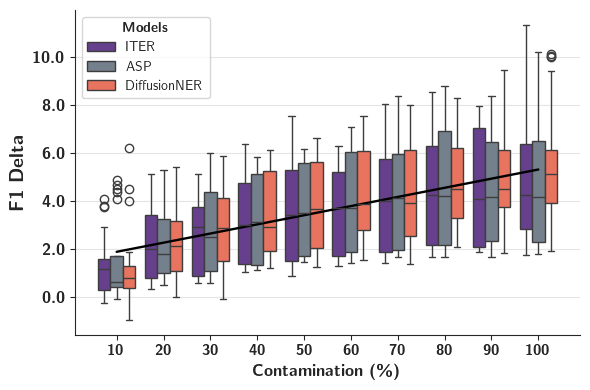

/tmp/ipykernel_415646/767529080.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_415646/767529080.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


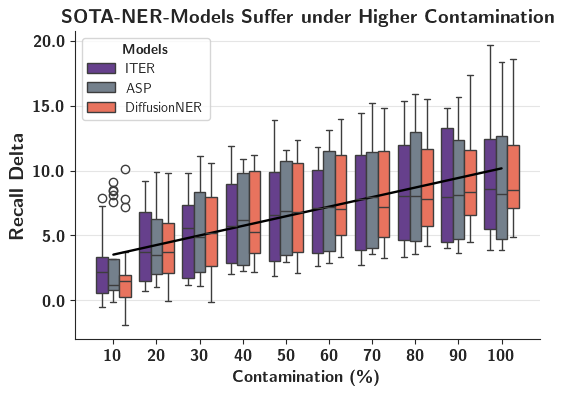

In [103]:
model_colors = {
    "diffusion": "tomato",
    # "diffusion": "lightcoral",
    "asp": "slategray",
    # "asp": "silver",
    "iter": "rebeccapurple",
    # "iter": "mediumpurple"
}
label2name = {"iter": "ITER", "asp": "ASP", "diffusion": "DiffusionNER",}
plt.rcParams.update({
    "text.usetex": True,
})
alpha=1
fontsize = 12
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
entire_df = entire_df[entire_df["conta_percent"] != 0.0]
sns.boxplot(data=entire_df, x="conta_percent", y="ner_f1_delta", palette=model_colors, hue="model", boxprops=dict(alpha=alpha), ax=ax)
#sns.stripplot(data=y, x="conta_percent", hue="dataset", palette="bright", y="ner_f1_delta", jitter=0.4, ax=ax)
# Calculate and plot regression line
unique_x = sorted(entire_df['conta_percent'].unique())
x_numeric = np.arange(len(unique_x))
line_colors = ["blue", "green", "orange"]
y_mean = [entire_df[(entire_df['conta_percent'] == val)]['ner_f1_delta'].mean() for val in unique_x]
m, b = np.polyfit(x_numeric, y_mean, 1)

ax.plot(x_numeric, m * x_numeric + b, color="black", linestyle='-', linewidth=1.7)
ax.grid(True, alpha=0.5, axis="y")
ax.set_ylabel(r"\textbf{F1 Delta}", fontsize=14)
ax.set_xlabel(r"\textbf{Contamination (\%)}", fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.set_xticklabels(
    [rf"\textbf{{{(x+1)*10}}}" for x in ax.get_xticks()],
    fontsize=11
)
ax.set_yticklabels(
    [rf"\textbf{{{x}}}" for x in ax.get_yticks()],
    fontsize=fontsize
)
ax.legend(handles=ax.get_legend_handles_labels()[0], labels=[label2name[l] for l in ax.get_legend_handles_labels()[1]], title=r"\textbf{Models}", loc="best")
# ax.set_ylim((-2.5, 15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("plots/F1DeteriorationSeenUnseenByModelAlt.pdf", dpi=300, bbox_inches='tight')
plt.show()

####################################################

plt.rcParams.update({
    "text.usetex": True,
})
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
entire_df = entire_df[entire_df["conta_percent"] != 0.0]
sns.boxplot(data=entire_df, x="conta_percent", y="ner_rec_delta",palette=model_colors, hue="model", boxprops=dict(alpha=alpha), ax=ax)
# Calculate and plot regression line
unique_x = sorted(entire_df['conta_percent'].unique())
x_numeric = np.arange(len(unique_x))
y_mean = [entire_df[(entire_df['conta_percent'] == val)]['ner_rec_delta'].mean() for val in unique_x]
m, b = np.polyfit(x_numeric, y_mean, 1)
ax.plot(x_numeric, m * x_numeric + b, color="black", linestyle='-', linewidth=1.7)
ax.grid(True, alpha=0.5, axis="y")

ax.set_ylabel(r"\textbf{Recall Delta}", fontsize=14)
ax.set_xlabel(r"\textbf{Contamination (\%)}", fontsize=fontsize)
ax.tick_params(axis='both', labelsize=12)
ax.set_xticklabels(
    [rf"\textbf{{{(x+1)*10}}}" for x in ax.get_xticks()],
    fontsize=fontsize
)
ax.set_yticklabels(
    [rf"\textbf{{{x}}}" for x in ax.get_yticks()],
    fontsize=fontsize
)
ax.legend(handles=ax.get_legend_handles_labels()[0], labels=[label2name[l] for l in ax.get_legend_handles_labels()[1]], title=r"\textbf{Models}", loc="best")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title(r"\textbf{SOTA-NER-Models Suffer under Higher Contamination}", fontsize=14 )
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

# ax.set_ylim((-1, 20 ))

# plt.tight_layout()
plt.savefig("plots/RecallDeteriorationSeenUnseenByModelAlt.pdf", dpi=300, bbox_inches='tight')
plt.show()

## Plot per class counts


In [ ]:
from typing import List
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 12,
    'figure.titlesize': 16
})
RELATED_COLUMNS = ["conta_percent", "split", "ent_conta_percent_normal"]
COL_WRAP_MAPPING = {"scierc": 3, "default": 4}


def prepare_data(df, dataset: str) -> pd.DataFrame:
    """Prepare and melt data for visualization."""
    filtered_df = df[df.dataset == dataset]
    # Get normal precision per class
    metric = "_pr" # "rec"
    filtered_df.columns = filtered_df.columns.str.lower()
    norm_pr_cols = [
        col for col in filtered_df.columns
        if metric in col and not col.split(metric)[0] + "_" in ["", "ner_", "macro_", "macro_ner_"] and "unseen" not in col and "_seen" not in col and "pre" not in col
    ]
    # Get clean recall per class
    metric = "rec"
    clean_rec_cols = [
        col for col in filtered_df.columns
        if metric in col and not col.split(metric)[0] in ["", "ner_", "macro_", "macro_ner_"] and "unseen" in col
    ]
    assert len(clean_rec_cols) == len(norm_pr_cols)
    melted_data_pr = filtered_df.melt(
        id_vars=["dataset", "split", "conta_percent", "model", "test"],
        value_vars=norm_pr_cols,
        var_name="ent_type",
        value_name="precision"
    )
    melted_data_pr["ent_type"] = melted_data_pr["ent_type"].str.split("_").str[0]
    melted_data_rec = filtered_df.melt(
        id_vars=["dataset", "split", "conta_percent", "model", "test"],
        value_vars=clean_rec_cols,
        var_name="ent_type",
        value_name="recall"
    )
    melted_data_rec["ent_type"] = melted_data_rec["ent_type"].str.split("_").str[0]
    melted_data = melted_data_pr.merge(melted_data_rec, on=["dataset", "split", "conta_percent", "model", "test", "ent_type"])
    melted_data["clean_f1"] = (2 * melted_data["precision"] * melted_data["recall"]) / (melted_data["precision"] + melted_data["recall"])
    return melted_data


def create_facet_grid(data: pd.DataFrame, dataset: str) -> sns.FacetGrid:
    """Create and configure FacetGrid visualization."""
    col_wrap = COL_WRAP_MAPPING.get(dataset, COL_WRAP_MAPPING["default"])
    sorted_entities = data.groupby("ent_type")["count"].median().sort_values().index

    grid = sns.FacetGrid(
        data=data,
        col="ent_type",
        col_order=sorted_entities,
        col_wrap=col_wrap,
        height=4,
        aspect=1.2,
    )
    #grid.fig.set_size_inches(12, 8)  # Ensuring fixed figure size
    # Explicitly set hue normalization
    vmin = data["count"].min()
    vmax = data["count"].max()
    grid.map_dataframe(
        sns.scatterplot,
        x="conta_percent",
        y="clean_f1",
        hue="count",
        palette="rocket",
        hue_norm=(vmin, vmax),  # Explicit normalization
        legend=False,
        s=50,
    )
    grid.set(yticks=list(range(round(int(data["clean_f1"].min())//20)*20-20,101, 20)))
    grid.set(ylim=(round(int(data["clean_f1"].min()), -1 ), None))


    return grid


def add_colorbar(fig, ax, data: pd.DataFrame):
    """Add standardized colorbar using plot-level min/max."""
    vmin = data["count"].min()
    vmax = data["count"].max()

    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap="rocket", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label="Class Counts")


def main_visualization_loop(datasets: List[str], x: pd.DataFrame, count_df: pd.DataFrame):
    """Main loop for generating visualizations."""
    print("Available datasets:", datasets)

    for dataset in datasets:

        melted_data = prepare_data(x, dataset)
        # Merge with count data
        merged_data = pd.merge(
            count_df[(count_df.dataset == dataset) & (count_df.dataset_split == "train")],
            melted_data,
            on=["dataset", "split", "conta_percent", "ent_type"]
        )
        grid = create_facet_grid(merged_data, dataset)
        # grid.set_axis_labels("Contamination %", "Recall")

        # Add colorbar to last subplot
        add_colorbar(grid.fig, grid.axes[-1], merged_data)
        grid.fig.subplots_adjust(top=0.85)
        grid.set_axis_labels("Contamination %", "F1 clean", fontsize=14)

        grid.set(xticks=[20, 40, 60, 80, 100])
        for ax in grid.axes.flat:
            ax.tick_params(axis='x', labelsize=12)  # Set x-axis tick font size
            ax.tick_params(axis='y', labelsize=12)  # Set y-axis tick font size

        grid.set_titles(col_template="Entity Type: {col_name}", fontsize=14)
        if dataset in ["nyt", "genia", "conll04",]:
            grid.fig.set_size_inches(12,3)
            grid.fig.suptitle(f"Dataset: {dataset_name_mapping[dataset]}", x=0.4 if dataset in ["nyt", "genia",] else 0.5, fontsize=15, y=1.03)
            grid.fig.subplots_adjust(wspace=0.3)
        elif dataset == "scierc":
            grid.fig.set_size_inches(9,5)
            grid.fig.suptitle(f"Dataset: {dataset_name_mapping[dataset]}", x=0.4 if dataset in ["nyt", "genia",] else 0.5, fontsize=15, y=0.95)
            grid.fig.subplots_adjust(wspace=0.3, hspace=0.32)
        else:
            grid.fig.set_size_inches(12,5)
            grid.fig.suptitle(f"Dataset: {dataset_name_mapping[dataset]}", x=0.4 if dataset in ["nyt", "genia",] else 0.5, fontsize=15, y=0.97)
            grid.fig.subplots_adjust(wspace=0.3)
            # Uniform figure size for all datasets
        plt.savefig(f"plots/{dataset}_per_class.pdf", dpi=300, bbox_inches='tight')
        plt.show()

datasets = ["nyt", "ace05", "genia", "conll04", "scierc"]
main_visualization_loop(datasets, entire_df, count_df)

#### compare Original dataset to Mincut by NE Class counts

In [ ]:
def get_split2entity_counts(ds_name, train_file=None, dev_file=None, test_file=None):
    split2entity_counts = dict()
    split2data = get_dataset(
        dataset_name=ds_name,
        train_file=train_file,
        dev_file=dev_file,
        test_file=test_file,
        type_file=f"{ds_name}_types.json",
        data_dir="datasets/"
    )
    for split, df in split2data.items():
        if split == "types" or df is None:
            continue
        split = split.split("_")[0]
        split2entity_counts[split] = Counter([ent["type"] for example in df["entities"] for ent in example])
    if "dev" not in split2entity_counts:
        split2entity_counts["dev"] = dict()
    return split2entity_counts

ratio = "mincut"
dataset2stats = dict()
for ds_name in ["conll03", "conll04", "scierc", "genia", "nyt", "ace05",]: #  "ade"]:
    print(ds_name)
    train_file = f"{ds_name}_train.json"
    dev_file = f"{ds_name}_dev.json"
    test_file = f"{ds_name}_test.json"
    dataset2stats[ds_name] = get_split2entity_counts(ds_name, train_file=train_file, dev_file=dev_file, test_file=test_file)

    train_file = f"{ds_name}_train_{ratio}.json"
    dev_file = f"{ds_name}_dev_{ratio}.json"
    test_file = f"{ds_name}_test_{ratio}.json"
    dataset2stats[ds_name + "_fair"] = get_split2entity_counts(ds_name, train_file, dev_file, test_file)


In [ ]:
# Count Entity types and output if one has to few samples
for ds_name, counts in dataset2stats.items():
    if "fair" in ds_name:
        continue
    fair_counts = dataset2stats[ds_name+"_fair"]
    for split in ["train", "dev", "test"]:
        if split in fair_counts and split in counts:
            if len(counts[split]) != len(fair_counts[split]):
                print("Missing Types", ds_name, split)
                # print(f"{sorted(fair_counts[split].keys())},\n{sorted(counts[split].keys())}")
                # print(counts, fair_counts)
            if any([1 if c < 20 else 0 for enttype, c in fair_counts[split].items()]):
                print("Fair Too few samples?", ds_name, split)
                # print(f"{sorted(fair_counts[split].keys())},\n{sorted(counts[split].keys())}")
                print(f"orig:{counts},\nfair:{fair_counts}")
            if any([1 if c < 20 else 0 for enttype, c in counts[split].items()]):
                print("Orig Too few samples?", ds_name, split)

#### Create Barplot for Entity Counts

In [ ]:
dataset2dsname = {"ace05": "ACE05", "conll03":"CoNLL03", "conll04":"CoNLL04", "ade":"ADE", "genia": "GENIA", "nyt": "NYT", "scierc": "SciERC"}
for dataset in dataset2stats.keys():
    if "fair" in dataset:
        continue
    # Create df from entity counts for plotting
    print(dataset)
    df = pd.DataFrame(dataset2stats[dataset]).reset_index().rename(columns={"index": 'EntType'})
    tmp = ["test"] if dataset in ["genia", "ade"] else ["dev", "test"]
    value_vars = [c for c in df.columns if c in tmp]
    entity_counts_df = pd.DataFrame(dataset2stats[dataset]).reset_index().rename(columns={"index": 'EntType'}).melt(
        id_vars="EntType", value_vars=value_vars, var_name="split", value_name="count"
    )
    entity_counts_df["option"] = "original"
    tmp = pd.DataFrame(dataset2stats[dataset + "_fair"]).reset_index().rename(columns={"index": 'EntType'}).melt(
        id_vars="EntType", value_vars=value_vars, var_name="split", value_name="count"
    )
    tmp["option"] = "fair"

    entity_counts_df = pd.concat([entity_counts_df, tmp], axis=0)

    # Pivot for stacking
    stacked_df = entity_counts_df.pivot_table(index=["split", "option"], columns="EntType", values="count",
                                              aggfunc="sum").fillna(0)
    # Define custom x positions
    split_order = value_vars if ds_name not in  ["genia", "ade"] else ["train", "test"]
    option_order = ["original", "fair"]

    x_positions = {}  # Store positions for x-axis
    base_x = 0  # Start position

    for split in split_order:
        for i, option in enumerate(option_order):
            x_positions[(split, option)] = base_x + i * 0.45  # Keep "original" and "fair" close
        base_x += 1  # Add gap before next split

    stacked_df["x_pos"] = [x_positions[idx] for idx in stacked_df.index]
    hatch_patterns = {"original": "", "fair": "\\"}  # No pattern for "original", striped for "fair"}

    fig, ax = plt.subplots(figsize=(5, 5))
    # Define colors (same for both "original" and "fair")
    #colors = plt.cm.gnuplot(np.linspace(0.03, 1, stacked_df.shape[1] - 1))
    colors = [plt.cm.tab20(i) for i in range(10)]
    # Plot stacked bars
    bottom = np.zeros(len(stacked_df))  # Track bottom for stacking
    for idx, ent_type in enumerate(stacked_df.columns[:-1]):  # Exclude x_pos column
        for option in option_order:
            mask = stacked_df.index.get_level_values("option") == option
            ax.bar(
                stacked_df.loc[mask, "x_pos"],
                stacked_df.loc[mask, ent_type],
                bottom=bottom[mask],
                label=f"{ent_type} ({option})" if option == "original" else None,  # Avoid duplicate legend
                color=colors[idx],
                hatch=hatch_patterns[option],
                width=0.4,
                edgecolor="black",
                alpha=0.75 if option == "fair" else 1.0,
                linewidth=0.4
            )

        bottom += stacked_df[ent_type]  # Update stacking positions
    # Set x-axis labels properly
    ax.set_xticks([np.mean([x_positions[(split, "original")], x_positions[(split, "fair")]]) for split in split_order])
    ax.set_xticklabels(split_order)
    # ax.set_yticklabels(labels = [math.e**float(item.get_text()) for item in ax.get_yticklabels()])
    ax.set_xlabel("Splits")
    ax.set_ylabel("Count")
    ax.set_title(f"{dataset2dsname[dataset]}")

    # Legend (Adding a separate fair-pattern example for clarity)
    import matplotlib.patches as mpatches

    fair_patch = mpatches.Patch(facecolor="white", edgecolor="black", hatch="\\\\\\", label="Fair Data")
    handles, labels = ax.get_legend_handles_labels()

    if dataset in ["genia", "ace05",]:
        ax.legend(handles + [fair_patch], [l.split()[0] for l in labels] + ["Clean"], title="Entity Type",
              bbox_to_anchor=(1, 1), loc='upper right')
    elif dataset in ["conll04", "conll03"]:
        ax.legend(handles + [fair_patch], [l.split()[0] for l in labels] + ["Clean"], title="Entity Type",
               bbox_to_anchor=(0.36, 1), loc='upper center')
    elif dataset in ["nyt", "ade"]:
        ax.legend(handles + [fair_patch], [l.split()[0] for l in labels] + ["Clean"], title="Entity Type",
               bbox_to_anchor=(0, 0), loc='lower left')
    elif dataset == "scierc":
        ax.legend(handles + [fair_patch], [l.split()[0] for l in labels] + ["Clean"], title="Entity Type",
           bbox_to_anchor=(0.25, 1), loc='upper center')
    plt.savefig(f"plots/{dataset2dsname[dataset]}OrigVsFair.pdf", bbox_inches='tight', dpi=300)
    plt.show()


#### Plot Original Clean and Contaminated splits

In [ ]:
dataset2stats = dict()
import warnings
warnings.filterwarnings("ignore")
for ds_name in ["conll04", "scierc", "genia", "nyt", "ace05", "conll03"]:
    test_file = f"{ds_name}_test.json"
    dataset2stats[ds_name] = get_split2entity_counts(ds_name, test_file=test_file)
    for conta in ["seen", "unseen"]:
        test_file = f"{ds_name}_{conta}_test.json"
        dataset2stats[ds_name + f"_{conta}"] = get_split2entity_counts(ds_name, test_file=test_file)


def dict_to_df(data):
    return pd.DataFrame(
        [(dset, split, ent, count) for dset, splits in data.items() for split, counter in splits.items() for ent, count
         in counter.items()],
        columns=["dataset", "split", "EntType", "count"]
    )


entity_counts_df = dict_to_df(dataset2stats)
entity_counts_df[["dataset", "option"]] = entity_counts_df['dataset'].str.split('_', n=1, expand=True).fillna(
    "original")

for dataset in ["conll04", "scierc", "genia", "nyt", "ace05"]:
    fig = plt.figure(figsize=(3.5, 2.5))
    clean_patch = mpatches.Patch(facecolor="white", edgecolor="black", hatch="\\\\\\", label="Clean")
    conta_patch = mpatches.Patch(facecolor="white", edgecolor="black", hatch="///", label="Contam.")

    colors = [plt.cm.tab20(i) for i in range(10)]
    ax = entity_counts_df[entity_counts_df.dataset == dataset].pivot_table(index=["split", "option"], columns="EntType",
                                                                           values="count", aggfunc="sum").fillna(
        0).plot.bar(stacked=True, color=colors, width=0.7)
    ax.set_xticklabels(["Original", "Contam.", "Clean"], rotation=45)
    ax.set_xlabel("Test sets")
    ax.set_title(f"{dataset_name_mapping[dataset]}")
    handles, labels = ax.get_legend_handles_labels()
    if dataset == "scierc":
        ax.legend(bbox_to_anchor=(0.29, 0.5),)
    # Apply hatch patterns to the entire bars (not just segments)
    bars_list = ax.patches
    bar_hatches = ["", "/", "\\"]
    num_bars = len(bars_list) // 3
    for i, bar in enumerate(bars_list):
        bar.set_hatch(bar_hatches[i % len(bar_hatches)])  # Cycle through hatches
    plt.savefig(f"plots/{dataset}_enttype_seenUnseenComparison.pdf", dpi=300, bbox_inches="tight")
    plt.show()


##### Compare models metrics with normal training and eval on normal testset + Seen and Unseen

# load full training metric files and display table


In [ ]:
asp_metrics = json.load(open("results/experiment_results/full_training/asp_metrics.json"))
iter_metrics = json.load(open("results/experiment_results/full_training/iter_metrics.json"))
_metrics = []
# load diff metrics
for dataset in ["conll04", "scierc", "genia", "nyt", "ace05"]:
    with open(f"results/experiment_results/full_training/diffusionner/{dataset}/metrics.json") as f:
        json_data = json.load(f)
        tmp_metrics = defaultdict(dict)
        for metric, score in json_data["test_metrics"].items():
            if "_prec_" not in metric and "_rec_" not in metric and "_f1_" not in metric:
                continue
            if metric.startswith("unseen"):
                m = rename_diff_metric(metric.split("_", maxsplit=1)[1])
                tmp_metrics["unseen"][m] = round(score / 100, 4)
            elif metric.startswith("seen"):
                m = rename_diff_metric(metric.split("_", maxsplit=1)[1])
                tmp_metrics["seen"][m] = round(score / 100, 4)
            else:
                m = rename_diff_metric(metric)
                tmp_metrics["normal"][m] = round(score / 100, 4)
        for testvalue in ["normal", "seen", "unseen"]:
            _metrics.append({
                "dataset": dataset,
                "test": testvalue,
                "model": "diffusion",
                "metrics": tmp_metrics[testvalue],
            })
# rename asp metrics
for dataset, scores in asp_metrics.items():
    tmp_metrics = defaultdict(dict)
    for test_value, metrics in scores.items():
        for metric, score in metrics.items():
            if "Precision" not in metric and "Recall" not in metric and "F1" not in metric:
                continue
            m = rename_asp_metric(metric)
            tmp_metrics[test_value][m] = round(score / 100, 4)
    for testvalue in ["normal", "seen", "unseen"]:
        _metrics.append({
            "dataset": dataset,
            "test": testvalue,
            "model": "asp",
            "metrics": tmp_metrics[testvalue],
        })

# rename iter metrics
for dataset, scores in iter_metrics.items():
    tmp_metrics = defaultdict(dict)
    for test_value, metrics in scores.items():
        for metric, score in metrics.items():
            tmp_metrics[test_value][metric] = round(score, 4)
    for testvalue in ["normal", "seen", "unseen"]:
        _metrics.append({
            "dataset": dataset,
            "test": testvalue,
            "model": "iter",
            "metrics": tmp_metrics[testvalue],
        })
metric_df = pd.DataFrame(_metrics)
metric_df = metric_df.join(pd.json_normalize(metric_df['metrics']).dropna(subset=["ner_f1"]))[["dataset", "test", "model", "ner_pr", "ner_rec", "ner_f1"]]
tmp = pd.merge(metric_df[metric_df.test=="normal"], metric_df[metric_df.test=="seen"],how="inner", on=["dataset", "model"], suffixes=("", "_contam"))
tmp2 = tmp.merge(metric_df[metric_df.test=="unseen"], how="inner", on=["dataset", "model"], suffixes=("", "_clean"))
tmp2["ner_f1_clean"] = (2*tmp2.ner_pr*tmp2.ner_rec_clean) / (tmp2.ner_pr + tmp2.ner_rec_clean)
tmp2["ner_f1_contam"] = (2*tmp2.ner_pr*tmp2.ner_rec_contam) / (tmp2.ner_pr + tmp2.ner_rec_contam)
tmp2["ner_f1_delta"] = tmp2["ner_f1"] - tmp2["ner_f1_clean"]
tmp2["ner_rec_delta"] = tmp2["ner_rec"] - tmp2["ner_rec_clean"]
tmp2[["dataset", "test", "model", "ner_pr", "ner_rec", "ner_f1", "ner_f1_clean", "ner_f1_contam", "ner_f1_delta", "ner_pr", "ner_rec", "ner_rec_contam", "ner_rec_clean", "ner_rec_delta"]]